In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk

In [111]:
dataset = 'cifar10'
model = 't2t_7'

In [112]:
with open(dataset+'_'+model+'/'+dataset+'_boosted_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        
lambdas = [0.01, 0.12, 0.14, 0.16,0.2, 0.4, 0.6, 0.8]
list_dicts_ours = []
for lamb in lambdas:
    with open(dataset+'_'+model+'/'+dataset+'_'+str(lamb)+'_results.pk', 'rb') as file:
        dicts = pk.load(file)
    list_dicts_ours.append(dicts)

In [127]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys = []
    C_keys = []
    for key in metrics.keys():
        if 'test/gen_cov' in key:
            alpha = key.split('test/gen_cov')[1]
            cov_key = 'test/gen_cov'+alpha
            C_key = 'test/gen_C'+alpha
            cov_keys.append(cov_key)
            C_keys.append(C_key)
    return cov_keys, C_keys

def find_highest_cov(metrics_we_care_about, cov_keys):
    alpha_max = 0
    requested_alpha = 0.5
    for cov_key in cov_keys:
        alpha_val = float(cov_key.split('_')[-1])
        emp_cov = metrics_we_care_about['average'+cov_key]
        print(emp_cov)
        if 1-emp_cov< requested_alpha:
            if alpha_max < alpha_val:
                alpha_max = alpha_val
                print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            
        
our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys, C_keys = get_all_cov_C(list_dicts_ours[0])
keys_we_want = keys_we_want + cov_keys + C_keys
for metrics in list_dicts_ours:
    
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])
    for cov_key in cov_keys:
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
    
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys)
    
    
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)

0.8114925396825396
switching fot 0.1
0.6981332539682539
switching fot 0.15
0.5978108730158731
switching fot 0.2
0.5042320238095238
switching fot 0.25
0.4225265079365079
0.3532934523809524
0.2880381349206349
0.23728757936507935
0.1967032142857143
0.8004758730158731
switching fot 0.1
0.5324227380952381
switching fot 0.15
0.3291998015873016
0.19369670634920635
0.11542992063492064
0.06953277777777779
0.04304500000000001
0.026439682539682534
0.017511904761904763
0.779920753968254
switching fot 0.1
0.508007619047619
switching fot 0.15
0.31066654761904766
0.17979146825396827
0.1039623015873016
0.06075138888888889
0.03708940476190477
0.02194345238095238
0.014001507936507937
0.7582277380952381
switching fot 0.1
0.48824194444444446
0.29539055555555555
0.1684086904761905
0.09673694444444444
0.056037698412698414
0.03378373015873016
0.01995007936507937
0.012893849206349206
0.7216975
switching fot 0.1
0.45958329365079365
0.27321702380952384
0.15335646825396826
0.08596051587301587
0.04791055555555555

In [86]:
boosted_df = pd.DataFrame()
for metrics in list_dict_boosted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    df = pd.DataFrame(data=metrics)
    boosted_df = pd.concat([df, boosted_df],axis=0, ignore_index=True)

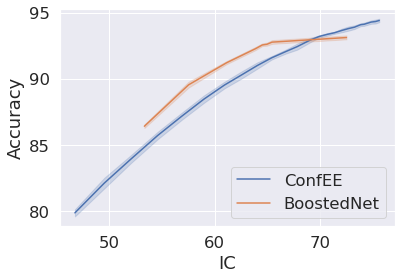

In [87]:
sns.set(font_scale=1.5)  # crazy big
filtered_boosted_df = boosted_df[boosted_df['average_IC'].between(45, 100)]
filtered_our_df = our_df[our_df['average_IC'].between(50, 100)]
sns.lineplot(data=filtered_boosted_df, x="average_IC", y="ACC", label="ConfEE")
sns.lineplot(data=filtered_our_df, x="average_IC", y="test/gated_acc", label="BoostedNet")
plt.xlabel('IC')
plt.ylabel('Accuracy')
plt.savefig('perf_cost_'+dataset+'.pdf')

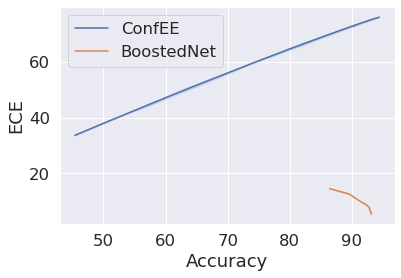

In [88]:
sns.set(font_scale=1.5)  # crazy big
filtered_boosted_df = boosted_df[boosted_df['average_ACC'].between(45, 100)]
filtered_our_df = our_df[our_df['average_ACC'].between(50, 100)]
sns.lineplot(data=filtered_boosted_df, x="average_ACC", y="ECE", label="ConfEE")
sns.lineplot(data=filtered_our_df, x="average_ACC", y="test/gated_ece", label="BoostedNet")
plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.savefig('perf_ece_'+dataset+'.pdf')